In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
sys.executable

'/home/joz608/.conda/envs/jupyter_launcher/bin/python3.8'

In [3]:
import sys
import os
import copy
import pathlib
import time
import gc

from tqdm import tqdm, trange
# from tqdm import trange

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import torch
import torchvision
import torchvision.transforms as transforms

# import cuml

# for creating validation set
import sklearn
from sklearn.model_selection import train_test_split

%matplotlib inline
%matplotlib inline
# %matplotlib inline
# %matplotlib qt

In [4]:
base_dir = '/n/data1/hms/neurobio/sabatini/josh'

In [5]:
import sys

sys.path.append(f'{base_dir}/github_repos')
# sys.path.append(f'/media/rich/Home_Linux_partition/github_repos')
dir_folders = f'{base_dir}/label_data'


%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import torch_helpers, math_functions, classification, h5_handling, plotting_helpers, indexing, misc #, decomposition
from GCaMP_ROI_classifier.new_stuff import util, models, training_simCLR, augmentation, training_classHead, training_supervised

## Import unlabeled training data

In [6]:
# data_unlabeled = h5_handling.simple_load(path=r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/masks_20211202_balanced.h5')
data_unlabeled = h5_handling.simple_load(path=f'{base_dir}/label_data/masks_20211202_balanced.h5')

masks_cat_raw = torch.as_tensor(np.concatenate((data_unlabeled['SYTmasks'], data_unlabeled['NPmasks'], data_unlabeled['RHmasks']), axis=0), dtype=torch.float32, device='cpu')

In [7]:
# data_labeled = h5_handling.simple_load(path=r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/masks_20211202_unbalanced.h5')

In [8]:
# masks_SYT = data_labeled['SYTmasks']
# labels_SYT = classification.squeeze_integers(data_labeled['SYTlabels'])

In [9]:
# nan_lst = np.concatenate(np.where(np.isnan(masks_SYT).sum(axis=-1).sum(axis=-1)))
# non_nan = [_ for _ in range(masks_SYT.shape[0]) if _ not in nan_lst]
# labels_SYT = labels_SYT[non_nan]
# masks_SYT = masks_SYT[non_nan]

In [10]:
# X_labeled_train_SYT, X_labeled_val_SYT, y_labeled_train_SYT, y_labeled_val_SYT = train_test_split(masks_SYT, labels_SYT, test_size = 0.2)

toss any NaNs

In [11]:
print(f'Number of masks: {masks_cat_raw.shape}')

ROIs_without_NaNs = torch.where(~torch.any(torch.any(torch.isnan(masks_cat_raw), dim=1), dim=1))[0]
masks_cat = masks_cat_raw[ROIs_without_NaNs]

print(f'Number of masks: {masks_cat.shape}')

Number of masks: torch.Size([711808, 36, 36])
Number of masks: torch.Size([711807, 36, 36])


## Import labeled training data

concatenated images shape: (9715, 32, 32)


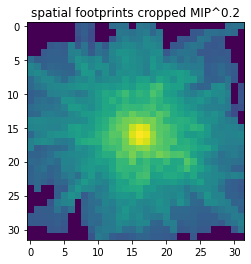

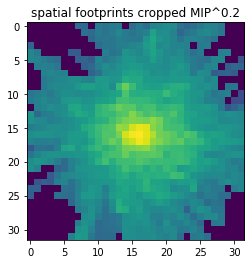

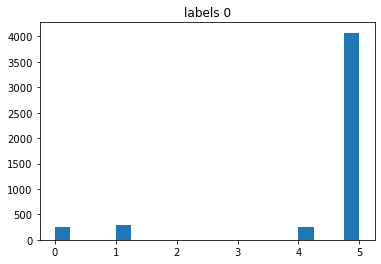

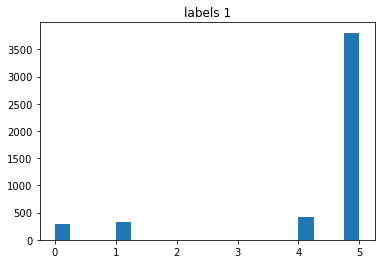

In [12]:
dir_folders = f'{base_dir}/label_data'
# dir_folders = r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data'
# dir_folders = r'/users/Josh/Documents/Harvard/label_data'
folders = [r'mouse 6_28 _ day 20200903/',
             r'mouse6_28 _ day20200815/']
fileNames_statFiles = [r'stat.npy']*len(folders)
paths_statFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_statFiles[ii] for ii in range(len(folders))]

sf_all = util.import_multiple_stat_files(   paths_statFiles=paths_statFiles,
                                            fileNames_statFiles=fileNames_statFiles,
                                            out_height_width=[32,32],
                                            max_footprint_width=241,
                                            plot_pref=True)
images_labeled_raw = np.concatenate(sf_all, axis=0)
images_labeled_raw = (images_labeled_raw / np.max(images_labeled_raw, axis=(1,2), keepdims=True)) * 1
print(f'concatenated images shape: {images_labeled_raw.shape}')

fileNames_labelFiles = ['labels_posthoc_filledIn_allCells.npy',
             'labels_posthoc_all.npy']
paths_labelFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_labelFiles[ii] for ii in range(len(folders))]

labels_all = util.import_multiple_label_files(paths_labelFiles=paths_labelFiles,
                                       plot_pref=True)
labels_raw = np.concatenate(labels_all)

assert np.alltrue([sf_all[ii].shape[0] == labels_all[ii].shape[0] for ii in range(len(sf_all))]) , 'num images in stat files does not correspond to num labels'

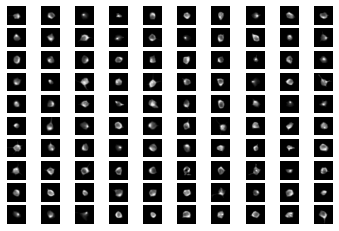

In [13]:
%matplotlib inline

plotting_helpers.plot_image_grid(images=images_labeled_raw,
                                labels=None,
                                grid_shape=(10,10), cmap=plt.get_cmap('gray'));

In [14]:
labels = classification.squeeze_integers(labels_raw)
images_labeled = images_labeled_raw[labels != 2]
labels = labels[labels != 2]
labels = classification.squeeze_integers(labels)

## Balance classes of inputs

In [15]:
duplicates = 1
balanced = True

images_dup = np.tile(images_labeled , (duplicates , 1 , 1))
labels_dup = np.tile(labels , (duplicates))

print(images_dup.shape)
print(labels_dup.shape)

if balanced:
    numToGetTo = np.sum(labels_dup==0)
    print(numToGetTo)
    for ii in np.array([1,2,3]):
  #     idxToDelete = np.cumsum(labels_dup==ii) <= (np.sum(labels_dup==ii) - numToGetTo)
        if ii==3:
            numToGetTo = np.sum(labels_dup==0)/1
        else:
            numToGetTo = np.sum(labels_dup==0)

        idxToDelete = (np.cumsum(labels_dup==ii) * (labels_dup==ii)) > numToGetTo
        images_dup = images_dup[idxToDelete==0,:,:]
        labels_dup = labels_dup[idxToDelete==0]





print(images_dup.shape)
print(labels_dup.shape)

numToGetTo = np.sum(labels_dup==0)
print(numToGetTo)

print(np.sum(labels_dup==0))
print(np.sum(labels_dup==1))
print(np.sum(labels_dup==4))
print(np.sum(labels_dup==5))
print(images_dup.shape)
print(labels_dup.shape)

(9714, 32, 32)
(9714,)
532
(2128, 32, 32)
(2128,)
532
532
532
0
0
(2128, 32, 32)
(2128,)


In [16]:
# create validation set

###### REMOVE WITH ENOUGH RAM
images = images_dup
labels = labels_dup

# X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup, labels_dup, test_size = 0.3)
X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup, labels_dup, test_size = 0.2)
# X_train, y_train = X_labeled_train, y_labeled_train

# X_labeled_val, X_test, y_labeled_val, y_test = train_test_split(X_labeled_val, y_labeled_val, test_size = 0.5)
X_val, X_test, y_val, y_test = train_test_split(X_labeled_val, y_labeled_val, test_size = 0.5)

(X_labeled_train.shape, y_labeled_train.shape), (X_labeled_val.shape, y_labeled_val.shape)

(((1702, 32, 32), (1702,)), ((426, 32, 32), (426,)))

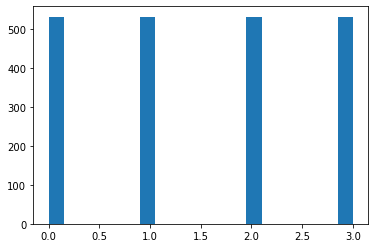

In [17]:
plt.figure()
plt.hist(labels_dup, 20);

In [18]:
images.shape

(2128, 32, 32)

# Train

In [19]:
DEVICE = torch_helpers.set_device(use_GPU=True)
# DEVICE = torch_helpers.set_device(use_GPU=False)

device: 'cuda'


### Define New model = model + pre-head + latent layer OR classification layer

In [20]:
class ModelTackOn(torch.nn.Module):
    def __init__(self, base_model, un_modified_model, pre_head_fc_sizes=[100], post_head_fc_sizes=[100], classifier_fc_sizes=None):
            super(ModelTackOn, self).__init__()
            self.base_model = base_model
            final_base_layer = list(un_modified_model.children())[-1]
            # final_base_layer = list(list(model.children())[-1].children())[-1]
            # print(final_base_layer)

            self.pre_head_fc_lst = []
            self.post_head_fc_lst = []
            self.classifier_fc_lst = []

            self.init_prehead(final_base_layer, pre_head_fc_sizes)
            self.init_posthead(pre_head_fc_sizes[-1], post_head_fc_sizes)
            if classifier_fc_sizes is not None:
                self.init_classifier(pre_head_fc_sizes[-1], classifier_fc_sizes)
    
    def init_prehead(self, prv_layer, pre_head_fc_sizes):
        for i, pre_head_fc in enumerate(pre_head_fc_sizes):
            if i == 0:
                in_features = prv_layer.in_features if hasattr(prv_layer,'in_features') else 512
            else:
                in_features = pre_head_fc_sizes[i - 1]
            fc_layer = torch.nn.Linear(in_features=in_features, out_features=pre_head_fc)
            self.add_module(f'PreHead_{i}', fc_layer)
            self.pre_head_fc_lst.append(fc_layer)

#             if i < len(pre_head_fc_sizes) - 1:
            non_linearity = torch.nn.ReLU()
            self.add_module(f'PreHead_{i}_NonLinearity', non_linearity)
            self.pre_head_fc_lst.append(non_linearity)

    def init_posthead(self, prv_size, post_head_fc_sizes):
        for i, post_head_fc in enumerate(post_head_fc_sizes):
            if i == 0:
                in_features = prv_size
            else:
                in_features = post_head_fc_sizes[i - 1]
            fc_layer = torch.nn.Linear(in_features=in_features, out_features=post_head_fc)
            self.add_module(f'PostHead_{i}', fc_layer)
            self.post_head_fc_lst.append(fc_layer)

            if i < len(post_head_fc_sizes) - 1:
                non_linearity = torch.nn.ReLU()
                self.add_module(f'PostHead_{i}_NonLinearity', non_linearity)
                self.pre_head_fc_lst.append(non_linearity)
    
    def init_classifier(self, prv_size, classifier_fc_sizes):
            for i, classifier_fc in enumerate(classifier_fc_sizes):
                if i == 0:
                    in_features = prv_size
                else:
                    in_features = classifier_fc_sizes[i - 1]
            fc_layer = torch.nn.Linear(in_features=in_features, out_features=classifier_fc)
            self.add_module(f'Classifier_{i}', fc_layer)
            self.classifier_fc_lst.append(fc_layer)

    def reinit_classifier(self):
        for i_layer, layer in enumerate(self.classifier_fc_lst):
            layer.reset_parameters()
    
#     def forward(self, X):
#         interim = self.base_model(X)
#         interim = self.get_head(interim)
#         interim = self.get_latent(interim)
#         return interim

    def forward_classifier(self, X):
        interim = self.base_model(X)
        interim = self.get_head(interim)
        interim = self.classify(interim)
        return interim

    def forward_latent(self, X):
        interim = self.base_model(X)
        interim = self.get_head(interim)
        interim = self.get_latent(interim)
        return interim


    def get_head(self, base_out):
        # print('base_out', base_out.shape)
        head = base_out
        for pre_head_layer in self.pre_head_fc_lst:
          # print('pre_head_layer', pre_head_layer.in_features)
          head = pre_head_layer(head)
          # print('head', head.shape)
        return head

    def get_latent(self, head):
        latent = head
        for post_head_layer in self.post_head_fc_lst:
            latent = post_head_layer(latent)
        return latent

    def classify(self, head):
        logit = head
        for classifier_layer in self.classifier_fc_lst:
            logit = classifier_layer(logit)
        return logit

    def set_pre_head_grad(self, requires_grad=True):
        for layer in self.pre_head_fc_lst:
            for param in layer.parameters():
                param.requires_grad = requires_grad
                
    def set_post_head_grad(self, requires_grad=True):
        for layer in self.post_head_fc_lst:
            for param in layer.parameters():
                param.requires_grad = requires_grad

    def set_classifier_grad(self, requires_grad=True):
        for layer in self.classifier_fc_lst:
            for param in layer.parameters():
                param.requires_grad = requires_grad

    def prep_contrast(self):
        self.set_pre_head_grad(requires_grad=True)
        self.set_post_head_grad(requires_grad=True)
        self.set_classifier_grad(requires_grad=False)

    def prep_classifier(self):
        self.set_pre_head_grad(requires_grad=False)
        self.set_post_head_grad(requires_grad=False)
        self.set_classifier_grad(requires_grad=True)


In [21]:
# import torchvision.models

# # base_model = torchvision.models.resnet101(pretrained=True)
# base_model = torchvision.models.resnet18(pretrained=True)

# for param in base_model.parameters():
#     param.requires_grad = False

# retrain = list(base_model.children())[-1:]
# for layer in retrain:
#     params = layer.parameters()
#     for param in params:
#         param.requires_grad = True

In [22]:
import torchvision.models

# base_model_frozen = torchvision.models.resnet101(pretrained=True)
base_model_frozen = torchvision.models.resnet18(pretrained=True)
# base_model_frozen = torchvision.models.wide_resnet50_2(pretrained=True)
# base_model_frozen = torchvision.models.resnet50(pretrained=True)
for param in base_model_frozen.parameters():
    param.requires_grad = False

start with a pretrained resnet model, and chop off the final layer. This will be used as the base on which we add the pre-head layers (for expressivity), latent layers (for simCLR), or classification layers (for post-hoc logistic regression)

In [23]:
model_chopped = torch.nn.Sequential(*(list(base_model_frozen.children())[:-1] + [torch.nn.Flatten()]))

### Make combined model
'model' has two forward methods. One for generating latents (for simCLR) and one for classifying labels

In [24]:
model = ModelTackOn(model_chopped, base_model_frozen, pre_head_fc_sizes=[1024, 512], post_head_fc_sizes=[64], classifier_fc_sizes=[len(np.unique(y_labeled_train))])
# model = ModelTackOn(model_chopped.to(DEVICE), base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
# model = ModelTackOn(model_chopped.to(DEVICE), base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])

# model = torch.nn.Sequential([model_chopped.to(DEVICE), torch.nn.Linear], pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])


# model = ModelTackOn(base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
# model = ModelTackOn(base_model, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
model.train();

In [25]:
# unfreeze particular blocks in ResNet model

for name, param in list(model.named_parameters()):
    if name[:10] == 'base_model':
        if int(name[11]) < 6:
            param.requires_grad = False
        elif int(name[11]) >= 6:
            param.requires_grad = True

for name, param in list(model.named_parameters()):
    if param.requires_grad:
        print(name)

base_model.6.0.conv1.weight
base_model.6.0.bn1.weight
base_model.6.0.bn1.bias
base_model.6.0.conv2.weight
base_model.6.0.bn2.weight
base_model.6.0.bn2.bias
base_model.6.0.downsample.0.weight
base_model.6.0.downsample.1.weight
base_model.6.0.downsample.1.bias
base_model.6.1.conv1.weight
base_model.6.1.bn1.weight
base_model.6.1.bn1.bias
base_model.6.1.conv2.weight
base_model.6.1.bn2.weight
base_model.6.1.bn2.bias
base_model.7.0.conv1.weight
base_model.7.0.bn1.weight
base_model.7.0.bn1.bias
base_model.7.0.conv2.weight
base_model.7.0.bn2.weight
base_model.7.0.bn2.bias
base_model.7.0.downsample.0.weight
base_model.7.0.downsample.1.weight
base_model.7.0.downsample.1.bias
base_model.7.1.conv1.weight
base_model.7.1.bn1.weight
base_model.7.1.bn1.bias
base_model.7.1.conv2.weight
base_model.7.1.bn2.weight
base_model.7.1.bn2.bias
PreHead_0.weight
PreHead_0.bias
PreHead_1.weight
PreHead_1.bias
PostHead_0.weight
PostHead_0.bias
Classifier_0.weight
Classifier_0.bias


## Define augmentation pipeline

In [26]:
import torchvision.transforms    

transforms = torch.nn.Sequential(
    
#     torchvision.transforms.RandomAdjustSharpness(torch.rand(1)*5, p=0.5),
#         torchvision.transforms.RandomPerspective(distortion_scale=0.7, 
#                                              p=0.5, 
#                                              interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
#                                              fill=0),
#     torchvision.transforms.GaussianBlur(kernel_size=5,
#                                         sigma=(0.0001, 0.1)),
        

    torchvision.transforms.RandomHorizontalFlip(p=0.5),
        
    torchvision.transforms.RandomAffine(
                                        degrees=(-180,180),
                                        translate=(0.2, 0.2),
                                        scale=(0.4, 1.3), 
                                        shear=(-25, 25, -25, 25), 
                                        interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
                                        fill=0, 
                                        fillcolor=None, 
                                        resample=None),
    augmentation.AddPoissonNoise(   scaler_bounds=(10**(4.0), 10**(6.)),
                                    prob=1,
                                    base=1000,
                                    scaling='log'),
    augmentation.AddGaussianNoise(  mean=0, 
                                    std=0.0002,
                                    prob=1),
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
    torchvision.transforms.Resize(size=(224,224),
                                  interpolation=torchvision.transforms.InterpolationMode.BILINEAR), 
    augmentation.AddPoissonNoise(   scaler_bounds=(10**(1.5), 10**(4.0)),
                                    prob=1,
                                    base=1000,
                                    scaling='log'),
    augmentation.AddGaussianNoise(  mean=0, 
                                    std=0.1,
                                    prob=1),
    augmentation.TileChannels(dim=0, n_channels=3),
#     augmentation.Normalize(  means=[0.485, 0.456, 0.406],
#                              stds=[0.229, 0.224, 0.225]),
#     torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225],
#                                      inplace=False),
#     torchvision.transforms.RandomHorizontalFlip(p=0.5),

#     torchvision.transforms.RandomAffine(
#                                         degrees=(-180,180),
#                                         translate=(0.0, 0.0),
#                                         interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
#                                         fill=0, 
#                                         # fillcolor=None, 
#                                         resample=None),
)
scripted_transforms = torch.jit.script(transforms)
# scripted_transforms = transforms

In [27]:
dataset_train = util.dataset_simCLR(
                                    torch.as_tensor(masks_cat, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(masks_cat.shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=2,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataloader_train = torch.utils.data.DataLoader( dataset_train,
#                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                batch_size=1024,
                                                shuffle=True,
                                                drop_last=True,
                                                pin_memory=True,
                                                num_workers=20,
                                                persistent_workers=True,
                                                # prefetch_factor=0
                                                )

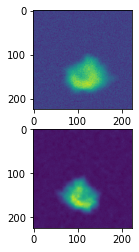

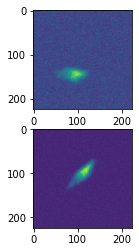

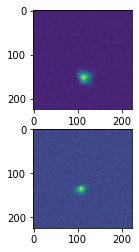

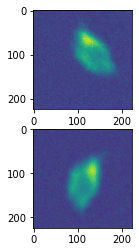

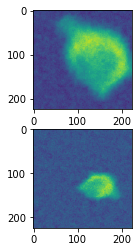

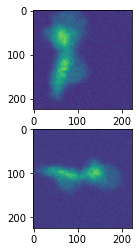

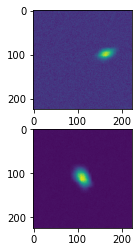

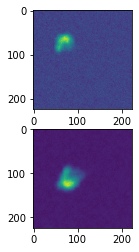

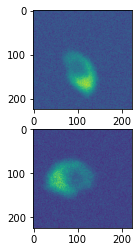

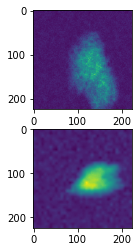

In [28]:
idx_rand = np.random.randint(0,masks_cat.shape[0], 10)
for ii in idx_rand:
    fig, axs = plt.subplots(2)
    axs[0].imshow(dataset_train[ii][0][0][0])
    axs[1].imshow(dataset_train[ii][0][1][0])

In [29]:
# torch_helpers.delete_all_cuda_tensors(globals())

import gc

torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()

0

## Training

In [ ]:
model.to(DEVICE)
model.prep_contrast()

In [ ]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# model = models.LeNet1(dropout_prob=0.3, momentum_val=0, n_output_features=64)


criterion = [CrossEntropyLoss()]
# criterion = CrossEntropyLoss(reduction='none')

# optimizer = Adam(model.parameters(), lr=1e-2, weight_decay=0.0)
# optimizer = Adam(model.parameters(), lr=2e-2)
optimizer = Adam(model.parameters(), lr=10**(-3.5))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=1-0.0000,
#                                                    gamma=1,
                                                  )

criterion = [_.to(DEVICE) for _ in criterion]
losses_train, losses_val, val_accs, acc = [], [np.nan], [], []

In [32]:
l2_alpha = 0.000

n_epochs=300000
for epoch in tqdm(range(n_epochs)):
    print(f'epoch: {epoch}')
    loss_rolling_train = training_simCLR.epoch_step(dataloader_train, 
                                    model, 
                                    optimizer, 
                                    criterion,
                                    scheduler=scheduler,
                                    temperature=1.0,
                                    # l2_alpha,
                                    mode='semi-supervised',
                                    loss_rolling_train=losses_train, 
                                    loss_rolling_val=losses_val,
                                    device=DEVICE, 
                                    verbose=2,
                                    verbose_update_period=1,
                                   
#                                     do_validation=False,
#                                     X_val=x_feed_through_val,
#                                     y_val=torch.as_tensor(y_val, device=DEVICE)
                                   )

  0%|          | 0/300000 [00:00<?, ?it/s]

epoch: 0
Iter: 0/695, loss_train: 7.6173, loss_val: nan, pos_over_neg: 1.0107152462005615 lr: 0.00031623
Iter: 1/695, loss_train: 7.507, loss_val: nan, pos_over_neg: 1.3537038564682007 lr: 0.00031623
Iter: 2/695, loss_train: 7.3535, loss_val: nan, pos_over_neg: 5.019804954528809 lr: 0.00031623
Iter: 3/695, loss_train: 7.2729, loss_val: nan, pos_over_neg: 4.096259593963623 lr: 0.00031623
Iter: 4/695, loss_train: 7.1938, loss_val: nan, pos_over_neg: 9.191800117492676 lr: 0.00031623
Iter: 5/695, loss_train: 7.1422, loss_val: nan, pos_over_neg: 18.821996688842773 lr: 0.00031623
Iter: 6/695, loss_train: 7.1229, loss_val: nan, pos_over_neg: 28.97947120666504 lr: 0.00031623
Iter: 7/695, loss_train: 7.0719, loss_val: nan, pos_over_neg: 25.66568946838379 lr: 0.00031623
Iter: 8/695, loss_train: 7.0655, loss_val: nan, pos_over_neg: 25.261159896850586 lr: 0.00031623
Iter: 9/695, loss_train: 7.0405, loss_val: nan, pos_over_neg: 28.13794708251953 lr: 0.00031623
Iter: 10/695, loss_train: 7.0279, loss

  0%|          | 1/300000 [21:09<105793:30:50, 1269.53s/it]

Iter: 694/695, loss_train: 6.7537, loss_val: nan, pos_over_neg: 12839.0302734375 lr: 0.00031623
epoch: 1
Iter: 0/695, loss_train: 6.7539, loss_val: nan, pos_over_neg: 13288.6357421875 lr: 0.00031623
Iter: 1/695, loss_train: 6.7512, loss_val: nan, pos_over_neg: 797.83544921875 lr: 0.00031623
Iter: 2/695, loss_train: 6.7574, loss_val: nan, pos_over_neg: 647.2567749023438 lr: 0.00031623
Iter: 3/695, loss_train: 6.7587, loss_val: nan, pos_over_neg: 810.3567504882812 lr: 0.00031623
Iter: 4/695, loss_train: 6.7566, loss_val: nan, pos_over_neg: 846.2191162109375 lr: 0.00031623
Iter: 5/695, loss_train: 6.7513, loss_val: nan, pos_over_neg: 1033.3253173828125 lr: 0.00031623
Iter: 6/695, loss_train: 6.7512, loss_val: nan, pos_over_neg: 697.2914428710938 lr: 0.00031623
Iter: 7/695, loss_train: 6.7565, loss_val: nan, pos_over_neg: 917.392822265625 lr: 0.00031623
Iter: 8/695, loss_train: 6.7587, loss_val: nan, pos_over_neg: 364.328857421875 lr: 0.00031623
Iter: 9/695, loss_train: 6.7581, loss_val: n

  0%|          | 2/300000 [41:38<103787:49:11, 1245.46s/it]

Iter: 694/695, loss_train: 6.7376, loss_val: nan, pos_over_neg: 465.9792175292969 lr: 0.00031623
epoch: 2
Iter: 0/695, loss_train: 6.7443, loss_val: nan, pos_over_neg: 662.1576538085938 lr: 0.00031623
Iter: 1/695, loss_train: 6.7418, loss_val: nan, pos_over_neg: 672.8501586914062 lr: 0.00031623
Iter: 2/695, loss_train: 6.7377, loss_val: nan, pos_over_neg: 1152.7266845703125 lr: 0.00031623
Iter: 3/695, loss_train: 6.7439, loss_val: nan, pos_over_neg: 571.3453369140625 lr: 0.00031623
Iter: 4/695, loss_train: 6.7389, loss_val: nan, pos_over_neg: 530.5828247070312 lr: 0.00031623
Iter: 5/695, loss_train: 6.7433, loss_val: nan, pos_over_neg: 4127.65234375 lr: 0.00031623
Iter: 6/695, loss_train: 6.7458, loss_val: nan, pos_over_neg: 499.7024841308594 lr: 0.00031623
Iter: 7/695, loss_train: 6.7407, loss_val: nan, pos_over_neg: 1266.490478515625 lr: 0.00031623
Iter: 8/695, loss_train: 6.7419, loss_val: nan, pos_over_neg: 1005.6187744140625 lr: 0.00031623
Iter: 9/695, loss_train: 6.7427, loss_val

  0%|          | 3/300000 [1:02:03<103023:43:34, 1236.30s/it]

Iter: 694/695, loss_train: 6.7326, loss_val: nan, pos_over_neg: 1235.13037109375 lr: 0.00031623
epoch: 3
Iter: 0/695, loss_train: 6.7367, loss_val: nan, pos_over_neg: 1135.476318359375 lr: 0.00031623
Iter: 1/695, loss_train: 6.7304, loss_val: nan, pos_over_neg: -16404.896484375 lr: 0.00031623
Iter: 2/695, loss_train: 6.7357, loss_val: nan, pos_over_neg: 1372.4642333984375 lr: 0.00031623
Iter: 3/695, loss_train: 6.7427, loss_val: nan, pos_over_neg: 1075.4288330078125 lr: 0.00031623
Iter: 4/695, loss_train: 6.7357, loss_val: nan, pos_over_neg: 679.4973754882812 lr: 0.00031623
Iter: 5/695, loss_train: 6.7328, loss_val: nan, pos_over_neg: 1848.31298828125 lr: 0.00031623
Iter: 6/695, loss_train: 6.7334, loss_val: nan, pos_over_neg: 1218.7276611328125 lr: 0.00031623
Iter: 7/695, loss_train: 6.7381, loss_val: nan, pos_over_neg: 1044.3087158203125 lr: 0.00031623
Iter: 8/695, loss_train: 6.7347, loss_val: nan, pos_over_neg: 1237.188720703125 lr: 0.00031623
Iter: 9/695, loss_train: 6.7352, loss_

  0%|          | 4/300000 [1:22:31<102748:43:52, 1233.00s/it]

Iter: 694/695, loss_train: 6.7327, loss_val: nan, pos_over_neg: 3275.5810546875 lr: 0.00031623
epoch: 4
Iter: 0/695, loss_train: 6.7309, loss_val: nan, pos_over_neg: 1501.8529052734375 lr: 0.00031623
Iter: 1/695, loss_train: 6.7296, loss_val: nan, pos_over_neg: 1389.182861328125 lr: 0.00031623
Iter: 2/695, loss_train: 6.7293, loss_val: nan, pos_over_neg: -18650.609375 lr: 0.00031623
Iter: 3/695, loss_train: 6.7338, loss_val: nan, pos_over_neg: -56871.203125 lr: 0.00031623
Iter: 4/695, loss_train: 6.7345, loss_val: nan, pos_over_neg: 11401.708984375 lr: 0.00031623
Iter: 5/695, loss_train: 6.7297, loss_val: nan, pos_over_neg: -4961.60791015625 lr: 0.00031623
Iter: 6/695, loss_train: 6.7353, loss_val: nan, pos_over_neg: 2356.6318359375 lr: 0.00031623
Iter: 7/695, loss_train: 6.7283, loss_val: nan, pos_over_neg: -23144.73046875 lr: 0.00031623
Iter: 8/695, loss_train: 6.7281, loss_val: nan, pos_over_neg: 1090.712646484375 lr: 0.00031623
Iter: 9/695, loss_train: 6.7256, loss_val: nan, pos_ov

  0%|          | 5/300000 [1:42:56<102521:11:34, 1230.27s/it]

Iter: 694/695, loss_train: 6.7265, loss_val: nan, pos_over_neg: 1687.196533203125 lr: 0.00031623
epoch: 5
Iter: 0/695, loss_train: 6.7265, loss_val: nan, pos_over_neg: 39539.95703125 lr: 0.00031623
Iter: 1/695, loss_train: 6.7283, loss_val: nan, pos_over_neg: 2171.3681640625 lr: 0.00031623
Iter: 2/695, loss_train: 6.7296, loss_val: nan, pos_over_neg: 1747.7191162109375 lr: 0.00031623
Iter: 3/695, loss_train: 6.733, loss_val: nan, pos_over_neg: 803.6704711914062 lr: 0.00031623
Iter: 4/695, loss_train: 6.7285, loss_val: nan, pos_over_neg: 1217.9127197265625 lr: 0.00031623
Iter: 5/695, loss_train: 6.7272, loss_val: nan, pos_over_neg: 25646.931640625 lr: 0.00031623
Iter: 6/695, loss_train: 6.7265, loss_val: nan, pos_over_neg: 17770.625 lr: 0.00031623
Iter: 7/695, loss_train: 6.726, loss_val: nan, pos_over_neg: 2762.118896484375 lr: 0.00031623
Iter: 8/695, loss_train: 6.7312, loss_val: nan, pos_over_neg: 6459.5205078125 lr: 0.00031623
Iter: 9/695, loss_train: 6.7349, loss_val: nan, pos_over

  0%|          | 6/300000 [2:03:21<102360:20:00, 1228.35s/it]

Iter: 694/695, loss_train: 6.7241, loss_val: nan, pos_over_neg: 1060.1329345703125 lr: 0.00031623
epoch: 6
Iter: 0/695, loss_train: 6.7216, loss_val: nan, pos_over_neg: 8584.767578125 lr: 0.00031623
Iter: 1/695, loss_train: 6.7231, loss_val: nan, pos_over_neg: -6842.67041015625 lr: 0.00031623
Iter: 2/695, loss_train: 6.7304, loss_val: nan, pos_over_neg: 1078.8582763671875 lr: 0.00031623
Iter: 3/695, loss_train: 6.7207, loss_val: nan, pos_over_neg: 1612.732177734375 lr: 0.00031623
Iter: 4/695, loss_train: 6.7271, loss_val: nan, pos_over_neg: 1455.43994140625 lr: 0.00031623
Iter: 5/695, loss_train: 6.729, loss_val: nan, pos_over_neg: -3420.458251953125 lr: 0.00031623
Iter: 6/695, loss_train: 6.7226, loss_val: nan, pos_over_neg: 866.9312744140625 lr: 0.00031623
Iter: 7/695, loss_train: 6.7246, loss_val: nan, pos_over_neg: 1519.5213623046875 lr: 0.00031623
Iter: 8/695, loss_train: 6.7303, loss_val: nan, pos_over_neg: 1185.0130615234375 lr: 0.00031623
Iter: 9/695, loss_train: 6.7287, loss_v

  0%|          | 7/300000 [2:23:49<102350:16:23, 1228.23s/it]

Iter: 694/695, loss_train: 6.7275, loss_val: nan, pos_over_neg: 1175.4503173828125 lr: 0.00031623
epoch: 7
Iter: 0/695, loss_train: 6.7247, loss_val: nan, pos_over_neg: 263996.9375 lr: 0.00031623
Iter: 1/695, loss_train: 6.7282, loss_val: nan, pos_over_neg: -27583.220703125 lr: 0.00031623
Iter: 2/695, loss_train: 6.729, loss_val: nan, pos_over_neg: -30641.97265625 lr: 0.00031623
Iter: 3/695, loss_train: 6.7256, loss_val: nan, pos_over_neg: 3883.1572265625 lr: 0.00031623
Iter: 4/695, loss_train: 6.7221, loss_val: nan, pos_over_neg: 1004.2064819335938 lr: 0.00031623
Iter: 5/695, loss_train: 6.7209, loss_val: nan, pos_over_neg: 11734.611328125 lr: 0.00031623
Iter: 6/695, loss_train: 6.7309, loss_val: nan, pos_over_neg: 1814.1044921875 lr: 0.00031623
Iter: 7/695, loss_train: 6.7268, loss_val: nan, pos_over_neg: 7015.68359375 lr: 0.00031623
Iter: 8/695, loss_train: 6.7249, loss_val: nan, pos_over_neg: -3521.602783203125 lr: 0.00031623
Iter: 9/695, loss_train: 6.7283, loss_val: nan, pos_over

  0%|          | 8/300000 [2:44:19<102394:59:59, 1228.77s/it]

Iter: 694/695, loss_train: 6.724, loss_val: nan, pos_over_neg: -5279.46728515625 lr: 0.00031623
epoch: 8
Iter: 0/695, loss_train: 6.7238, loss_val: nan, pos_over_neg: 1182.5009765625 lr: 0.00031623
Iter: 1/695, loss_train: 6.724, loss_val: nan, pos_over_neg: -6268.818359375 lr: 0.00031623
Iter: 2/695, loss_train: 6.7217, loss_val: nan, pos_over_neg: 1354.230712890625 lr: 0.00031623
Iter: 3/695, loss_train: 6.7192, loss_val: nan, pos_over_neg: 2162.719482421875 lr: 0.00031623
Iter: 4/695, loss_train: 6.7244, loss_val: nan, pos_over_neg: 1356.3486328125 lr: 0.00031623
Iter: 5/695, loss_train: 6.7198, loss_val: nan, pos_over_neg: 4152.05419921875 lr: 0.00031623
Iter: 6/695, loss_train: 6.7171, loss_val: nan, pos_over_neg: -8624.2880859375 lr: 0.00031623
Iter: 7/695, loss_train: 6.7207, loss_val: nan, pos_over_neg: 1606.7613525390625 lr: 0.00031623
Iter: 8/695, loss_train: 6.7214, loss_val: nan, pos_over_neg: 846.0708618164062 lr: 0.00031623
Iter: 9/695, loss_train: 6.7212, loss_val: nan, 

  0%|          | 9/300000 [3:04:59<102689:18:07, 1232.31s/it]

Iter: 694/695, loss_train: 6.7205, loss_val: nan, pos_over_neg: 763.2122802734375 lr: 0.00031623
epoch: 9
Iter: 0/695, loss_train: 6.7221, loss_val: nan, pos_over_neg: -9064.908203125 lr: 0.00031623
Iter: 1/695, loss_train: 6.7135, loss_val: nan, pos_over_neg: -3323.0625 lr: 0.00031623
Iter: 2/695, loss_train: 6.7193, loss_val: nan, pos_over_neg: -16924.005859375 lr: 0.00031623
Iter: 3/695, loss_train: 6.7224, loss_val: nan, pos_over_neg: -2077.4873046875 lr: 0.00031623
Iter: 4/695, loss_train: 6.7214, loss_val: nan, pos_over_neg: 2589.080322265625 lr: 0.00031623
Iter: 5/695, loss_train: 6.7183, loss_val: nan, pos_over_neg: 14509.1318359375 lr: 0.00031623
Iter: 6/695, loss_train: 6.7202, loss_val: nan, pos_over_neg: 2702.14013671875 lr: 0.00031623
Iter: 7/695, loss_train: 6.7237, loss_val: nan, pos_over_neg: 1370.58056640625 lr: 0.00031623
Iter: 8/695, loss_train: 6.72, loss_val: nan, pos_over_neg: 5336.96875 lr: 0.00031623
Iter: 9/695, loss_train: 6.7208, loss_val: nan, pos_over_neg: 

  0%|          | 10/300000 [3:25:26<102563:27:29, 1230.80s/it]

Iter: 694/695, loss_train: 6.7195, loss_val: nan, pos_over_neg: -210944.890625 lr: 0.00031623
epoch: 10
Iter: 0/695, loss_train: 6.723, loss_val: nan, pos_over_neg: 5428.80078125 lr: 0.00031623
Iter: 1/695, loss_train: 6.7172, loss_val: nan, pos_over_neg: -57371.1015625 lr: 0.00031623
Iter: 2/695, loss_train: 6.7169, loss_val: nan, pos_over_neg: -6875.4365234375 lr: 0.00031623
Iter: 3/695, loss_train: 6.72, loss_val: nan, pos_over_neg: 11134.13671875 lr: 0.00031623
Iter: 4/695, loss_train: 6.7174, loss_val: nan, pos_over_neg: -4872.36767578125 lr: 0.00031623
Iter: 5/695, loss_train: 6.7142, loss_val: nan, pos_over_neg: 3241.059814453125 lr: 0.00031623
Iter: 6/695, loss_train: 6.7199, loss_val: nan, pos_over_neg: 1473.2508544921875 lr: 0.00031623
Iter: 7/695, loss_train: 6.7195, loss_val: nan, pos_over_neg: 5380.59521484375 lr: 0.00031623
Iter: 8/695, loss_train: 6.7167, loss_val: nan, pos_over_neg: 1831.628173828125 lr: 0.00031623
Iter: 9/695, loss_train: 6.7221, loss_val: nan, pos_ove

  0%|          | 11/300000 [3:46:02<102674:38:11, 1232.14s/it]

Iter: 694/695, loss_train: 6.7165, loss_val: nan, pos_over_neg: 58335.6484375 lr: 0.00031623
epoch: 11


  0%|          | 11/300000 [3:46:23<102901:01:38, 1234.86s/it]
Exception in thread Thread-9:
Traceback (most recent call last):
  File "/home/joz608/.conda/envs/jupyter_launcher/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/joz608/.conda/envs/jupyter_launcher/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/joz608/.conda/envs/jupyter_launcher/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 28, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/home/joz608/.conda/envs/jupyter_launcher/lib/python3.8/multiprocessing/queues.py", line 116, in get
    return _ForkingPickler.loads(res)
  File "/home/joz608/.conda/envs/jupyter_launcher/lib/python3.8/site-packages/torch/multiprocessing/reductions.py", line 289, in rebuild_storage_fd
    fd = df.detach()
  File "/home/joz608/.conda/envs/jupyter_launcher/lib/python3.8/multiprocessing/resource

KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

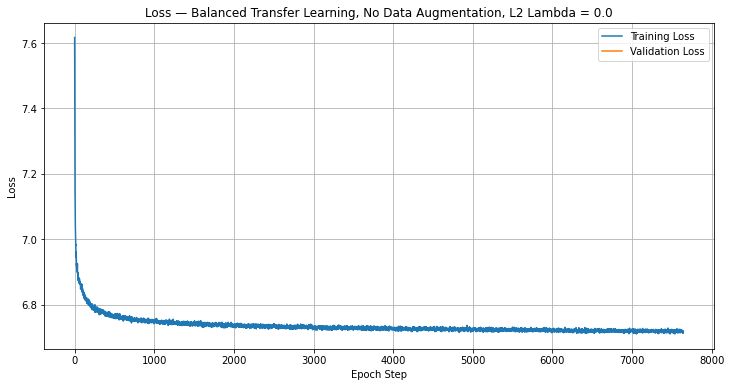

In [33]:
# import seaborn as sns
# sns.set(style='white', palette='bright', context='poster')
plt.rcdefaults()

%matplotlib inline
plt.figure(figsize=(12,6))
plt.plot(losses_train, label='Training Loss')
plt.plot(losses_val, label='Validation Loss')
plt.title(f'Loss — Balanced Transfer Learning, No Data Augmentation, L2 Lambda = {l2_alpha}')
plt.legend()
plt.grid()
plt.xlabel('Epoch Step')
plt.ylabel('Loss')
# plt.savefig('./Training-Loss.png')

In [34]:
model_file_name = 'ResNet18_simCLR_model_202112078_temp=1.0'

# torch.save(model.state_dict(), '/media/rich/Home_Linux_partition/github_repos/GCaMP_ROI_classifier/new_stuff/models/ResNet18_simCLR_model_20211205_3.pth')
torch.save(model.state_dict(), f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/models/{model_file_name}.pth')

In [ ]:
# model.load_state_dict(torch.load('/media/rich/Home_Linux_partition/github_repos/GCaMP_ROI_classifier/new_stuff/models/ResNet18_simCLR_model_20211205_2.pth'))
model.load_state_dict(torch.load(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/models/{model_file_name}.pth'))

In [35]:
losses_train_npy = np.array(losses_train)
losses_val_npy = np.array(losses_val)
val_accs_npy = np.array(val_accs)
acc_npy = np.array(acc)

np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_losses_train.npy', losses_train_npy)
np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_losses_val.npy', losses_val_npy)
np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_val_accs.npy', val_accs_npy)
np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_tr_accs.npy', acc_npy)

## Train classifier using classifier layers of model (or do supervised learning)

Freeze pre-head layers, unfreeze classification layers

Define labeled dataset to use

Train model

In [ ]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

criterion = [CrossEntropyLoss()]
# criterion = CrossEntropyLoss(reduction='none')

# optimizer = Adam(model.parameters(), lr=1e-2, weight_decay=0.0)
# optimizer = Adam(model.parameters(), lr=2e-2)
optimizer = Adam(model.parameters(), lr=10**(-4.5))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=1-0.0000,
#                                                    gamma=1,
                                                  )
criterion = [_.to(DEVICE) for _ in criterion]
losses_train, losses_val, val_accs, acc = [], [np.nan], [], []

In [ ]:
def transform_null(var):
    return(var)

In [ ]:
model.reinit_classifier()
model.train()
model.prep_classifier()

In [ ]:
dataset_validation = util.dataset_simCLR(
                                    torch.as_tensor(masks_cat, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(masks_cat.shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=1,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms_validation,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataloader_validation = torch.utils.data.DataLoader( dataset_validation,
#                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                batch_size=1024,
                                                shuffle=True,
                                                drop_last=True,
                                                pin_memory=True,
                                                num_workers=32,
                                                persistent_workers=True,
                                                # prefetch_factor=0
                                                )

In [ ]:
data_unlabeled = torch.as_tensor(masks_cat, dtype=torch.float32, device='cpu')

# model.to(DEVICE)

l2_alpha = 0.000

n_epochs=300000
for epoch in range(n_epochs):
    print(f'epoch: {epoch}')
    loss_rolling_train = training_simCLR.epoch_step(dataloader_validation, 
                                    model, 
                                    optimizer, 
                                    criterion, 

                                    # penalized_params, l2_alpha,

                                    scheduler=scheduler,
                                    L2_alpha=0.04,
                                    mode='supervised',
                                    loss_rolling_train=losses_train, 
                                    device=DEVICE, 
                                    loss_rolling_val=losses_val,
                                    verbose=2,
                                    verbose_update_period=1,
                                   
#                                     do_validation=False,
#                                     X_val=x_feed_through_val,
#                                     y_val=torch.as_tensor(y_val, device=DEVICE)
                                   )

Evalculate model

In [ ]:
%matplotlib notebook

plt.figure()
plt.plot(loss_rolling_train)

data_in = torch.as_tensor(X_labeled_val, dtype=torch.float32, device=DEVICE)
# data_in = torch.as_tensor(X_labeled_train, dtype=torch.float32, device=DEVICE)
data_in = util.tile_channels(data_in[:,None,...], dim=1)
proba = torch.nn.functional.softmax(model.forward_classifier(data_in), dim=1)
cm = classification.confusion_matrix(proba.detach().cpu().numpy(), y_labeled_val)
# cm = classification.confusion_matrix(proba.detach().cpu().numpy(), y_labeled_train)

plt.figure()
plt.imshow(cm, aspect='auto')
plt.colorbar()

In [ ]:
%matplotlib notebook
data_in = torch.as_tensor(X_labeled_train, dtype=torch.float32, device=DEVICE)
data_in = util.tile_channels(data_in[:,None,...], dim=1)
proba = torch.nn.functional.softmax(model.forward_classifier(data_in), dim=1)
cm = classification.confusion_matrix(proba.detach().cpu().numpy(), y_labeled_train)

plt.figure()
plt.imshow(cm)
plt.colorbar()

## Use sklearn to train classifier

In [36]:
transforms_validation = torch.nn.Sequential(
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
    torchvision.transforms.Resize(size=(224,224),
                                  interpolation=torchvision.transforms.InterpolationMode.BILINEAR), 
    augmentation.TileChannels(dim=0, n_channels=3),
#     augmentation.Normalize(  means=[0.485, 0.456, 0.406],
#                              stds=[0.229, 0.224, 0.225]),
#     torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225],
#                                      inplace=False),
)
scripted_transforms_validation = torch.jit.script(transforms_validation)
# scripted_transforms = transforms


In [37]:
dataset_labeled_train = util.dataset_simCLR(
                                    torch.as_tensor(X_labeled_train, device='cpu', dtype=torch.float32), 
                                    # torch.as_tensor(X_labeled_train_SYT, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(X_labeled_train.shape[0]), device='cpu', dtype=torch.float32),
                                    # torch.as_tensor(torch.zeros(X_labeled_train_SYT.shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=1,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms_validation,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataset_labeled_val = util.dataset_simCLR(
                                    torch.as_tensor(X_labeled_val, device='cpu', dtype=torch.float32), 
                                    # torch.as_tensor(X_labeled_val_SYT, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(X_labeled_val.shape[0]), device='cpu', dtype=torch.float32),
                                    # torch.as_tensor(torch.zeros(X_labeled_val_SYT.shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=1,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms_validation,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataloader_labeled_train = torch.utils.data.DataLoader( dataset_labeled_train,
    #                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                    batch_size=1024,
                                                    shuffle=False,
                                                    drop_last=False,
                                                    pin_memory=True,
                                                    num_workers=32,
                                                    persistent_workers=True,
                                                    # prefetch_factor=0
                                                    )
dataloader_labeled_val = torch.utils.data.DataLoader( dataset_labeled_val,
    #                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                    batch_size=1024,
                                                    shuffle=False,
                                                    drop_last=False,
                                                    pin_memory=True,
                                                    num_workers=32,
                                                    persistent_workers=True,
                                                    # prefetch_factor=0
                                                    )

/home/joz608/.conda/envs/jupyter_launcher/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 20, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [38]:
DEVICE = torch_helpers.set_device(use_GPU=True)

device: 'cuda'


In [39]:
model.eval()
model.to(DEVICE)
features_train = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dataloader_labeled_train], dim=0)
features_val   = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dataloader_labeled_val], dim=0)

run a sweep of logistic regressions over C (1/L2) parameter

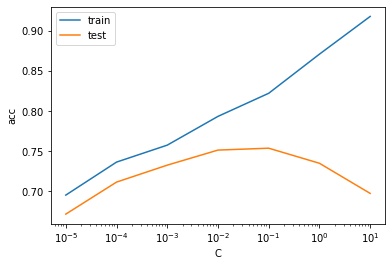

In [40]:
acc_train, acc_val = [], []
# C_toUse = np.array([1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001])
C_toUse = np.array([10,1,0.1,0.01,0.001,0.0001,0.00001])
for C in C_toUse:
#     print(f'C = {C}')
    logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
#     tic = time.time()
    logreg.fit(features_train, y_labeled_train)
#     print(f'time: {time.time() - tic}')
    acc = logreg.score(features_train, y_labeled_train)
    acc_train.append(acc)
#     print(f'acc_train: {acc}')
    acc = logreg.score(features_val, y_labeled_val)
    acc_val.append(acc)
#     print(f'acc_val: {acc}')
#     print('')
    

plt.figure()
plt.plot(C_toUse, acc_train)
plt.plot(C_toUse, acc_val)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('acc')
plt.legend(['train', 'test']);

In [41]:
# acc_train, acc_val = [], []
# # C_toUse = np.array([1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001])
# # C_toUse = np.array([10,1,0.1,0.01,0.001,0.0001,0.00001])
# C_toUse = np.array([10000])
# for C in tqdm(C_toUse):
# #     print(f'C = {C}')
#     logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
# #     tic = time.time()
#     logreg.fit(features_train, y_labeled_train_SYT)
# #     print(f'time: {time.time() - tic}')
#     acc = logreg.score(features_train, y_labeled_train_SYT)
#     acc_train.append(acc)
# #     print(f'acc_train: {acc}')
#     acc = logreg.score(features_val, y_labeled_val_SYT)
#     acc_val.append(acc)
# #     print(f'acc_val: {acc}')
# #     print('')
    

# plt.figure()
# plt.plot(C_toUse, acc_train)
# plt.plot(C_toUse, acc_val)
# plt.xscale('log')
# plt.xlabel('C')
# plt.ylabel('acc')
# plt.legend(['train', 'test']);

run a sinlg logistic regression with desired parameters and check confusion matrix

In [42]:
logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=10**(-1)).fit(features_train, y_labeled_train)

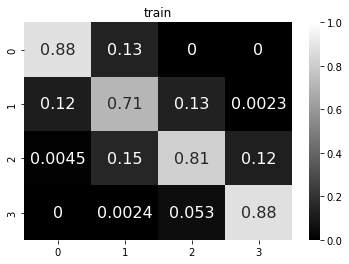

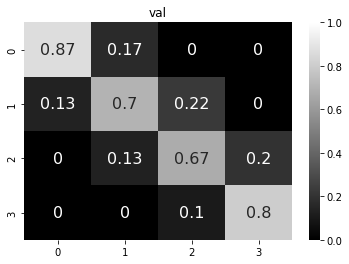

In [44]:
%matplotlib inline
proba = logreg.predict_proba(features_train)

preds = np.argmax(proba, axis=1)
cm = classification.confusion_matrix(preds, y_labeled_train)

plt.figure()
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
plt.title('train');

proba = logreg.predict_proba(features_val)
preds = np.argmax(proba, axis=1)
cm = classification.confusion_matrix(preds, y_labeled_val)

plt.figure()
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
plt.title('val');


In [45]:
# %matplotlib notebook
# proba = logreg.predict_proba(features_train)

# preds = np.argmax(proba, axis=1)
# cm = classification.confusion_matrix(preds, y_labeled_train_SYT)

# plt.figure()
# sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
# plt.title('train');

# proba = logreg.predict_proba(features_val)
# preds = np.argmax(proba, axis=1)
# cm = classification.confusion_matrix(preds, y_labeled_val_SYT)

# plt.figure()
# sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
# plt.title('val');


## Check embeddings

In [ ]:
model.eval();
# model.to(DEVICE);

In [ ]:
torch.cuda.empty_cache()

In [ ]:
dataset_unlabeled_noAug = util.dataset_simCLR(
                                    torch.as_tensor(masks_cat[:], device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(masks_cat[:].shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=1,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms_validation,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataloader_unlabeled_noAug = torch.utils.data.DataLoader( dataset_unlabeled_noAug,
#                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                batch_size=1024,
                                                shuffle=False,
                                                drop_last=False,
                                                pin_memory=True,
                                                num_workers=32,
                                                persistent_workers=True,
                                                # prefetch_factor=0
                                                )

In [ ]:
dataset_unlabeled_noAug = util.dataset_simCLR(
                                    torch.as_tensor(masks_SYT[:], device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(masks_SYT[:].shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=1,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms_validation,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataloader_unlabeled_noAug = torch.utils.data.DataLoader( dataset_unlabeled_noAug,
#                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                batch_size=1024,
                                                shuffle=False,
                                                drop_last=False,
                                                pin_memory=True,
                                                num_workers=32,
                                                persistent_workers=True,
                                                # prefetch_factor=0
                                                )

In [ ]:
# optional: run unlabeled data through model
features_train = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dataloader_unlabeled_noAug], dim=0)

In [ ]:
### REMOVE

DEVICE='cuda'
# DEVICE='cpu'

In [ ]:
# model.to(DEVICE);

In [ ]:
_, features_embedded, _, evr = decomposition.torch_pca(features_train, device=DEVICE, return_cpu=True)

In [ ]:
tsne = cuml.TSNE( n_components=2,
                  perplexity=50.0,
                  early_exaggeration=12.0,
#                   late_exaggeration=1.0,
                  learning_rate=200.0,
                  n_iter=1000,
                  n_iter_without_progress=300,
                  min_grad_norm=1e-07,
                  metric='euclidean',
                  init='random',
                  verbose=False,
#                   random_state=None,
#                   method='barnes_hut',
#                   angle=0.5,
#                   learning_rate_method='adaptive',
# #                   n_neighbors=90,
#                   perplexity_max_iter=100,
#                   exaggeration_iter=250,
#                   pre_momentum=0.5,
#                   post_momentum=0.8,
# #                   square_distances=True,
#                   handle=None,
#                   output_type=None
                )
features_embedded = tsne.fit_transform(features_train.to(DEVICE)).get()

In [ ]:
umap = cuml.UMAP(n_neighbors=100,
                n_components=2,
                n_epochs=None,
                learning_rate=1.0,
                min_dist=0.1,
                spread=1.0,
                set_op_mix_ratio=1.0, 
                local_connectivity=1.0,
                repulsion_strength=1.0, 
                negative_sample_rate=5, 
                transform_queue_size=4.0, 
                init='spectral', 
                verbose=False,
                a=None, 
                b=None, 
                target_n_neighbors=- 1, 
#                 target_weight=0.5, 
                target_metric='categorical', 
                handle=None,                
                hash_input=False, 
                random_state=None, 
                callback=None, 
                output_type=None
                )
features_embedded = umap.fit_transform(features_train.to(DEVICE)).get()

In [ ]:
import matplotlib as mpl

# mpl.rcParams['image.cmap'] = 'Set1'
%matplotlib notebook
plt.figure()
plt.scatter(features_embedded[:,0], features_embedded[:,1], s=10, c=labels_SYT, cmap=plt.get_cmap('tab10'))
# plt.scatter(features_embedded[:,0], features_embedded[:,1], s=0.001)
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=labels[labels!=3])
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y_val)
# plt.scatter(features_embedded[:,4], features_embedded[:,5], c=y_train)
# plt.scatter(features_embedded[:,11], features[:,43].cpu(), c=y_train)


In [ ]:
import matplotlib as mpl

# mpl.rcParams['image.cmap'] = 'Set1'
%matplotlib notebook
plt.figure()
# plt.scatter(features_embedded[:,0], features_embedded[:,1], s=30, c=y_labeled_train, cmap=plt.get_cmap('tab10'))
plt.scatter(features_embedded[:,0], features_embedded[:,1], s=0.2)
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=labels[labels!=3])
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y_val)
# plt.scatter(features_embedded[:,4], features_embedded[:,5], c=y_train)
# plt.scatter(features_embedded[:,11], features[:,43].cpu(), c=y_train)


In [ ]:
plt.figure()
plt.imshow(features_train.cpu().detach(), aspect='auto', interpolation='antialiased')

In [ ]:
plt.figure()
plt.plot(evr)
# plt.yscale('log')

In [ ]:
plt.figure()
plt.plot(evr)
# plt.yscale('log')

In [ ]:
plt.figure()
plt.plot(evr)
# plt.yscale('log')

In [ ]:
plt.figure()
plt.plot(evr)
# plt.yscale('log')

## Check filters

In [ ]:
list(model.state_dict().keys())

In [ ]:
layer_1 = model.state_dict()['base_model.0.weight'].cpu()
layer_2 = model.state_dict()['base_model.4.0.conv1.weight'].cpu()
layer_3 = model.state_dict()['base_model.7.0.conv1.weight'].cpu()
layer_4 = model.state_dict()['base_model.7.1.conv2.weight'].cpu()

plt.figure()
for ii in range(layer_1.shape[1]):
    for jj in range(layer_1.shape[0]):
        plt.subplot2grid((layer_1.shape[1],layer_1.shape[0]),(ii,jj))
        fig = plt.imshow(layer_1[jj,ii,:,:] , clim=(-0.2,0.2))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_2[jj,ii,:,:], clim=(-.05,.05))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_3[jj, ii,:,:], clim=(-.1,.1))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_4[jj, ii,:,:], clim=(-.1,.1))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

In [ ]:
# torch.save(model.state_dict(), '/media/rich/bigSSD/Net_trainedOnAug_20211025_trainingSet_mouse628_20200903and20200815_simCLR.pth')

In [ ]:
# model = Net()
# model.load_state_dict(torch.load('test_save.pth'))
# model.eval()

# Graveyard

In [ ]:
data_unlabeled = torch.as_tensor(masks_cat, dtype=torch.float32, device='cpu')

model.to(DEVICE)

# penalized_params = list(model.modules())[-1].parameters()
# penalized_params = torch.cat([_.view(-1) for _ in penalized_params], -1)

early_stopping = 50
prv_best_val = np.inf
early_stopping_cnt = 0

l2_alpha = 0.1

n_epochs=300000
for epoch in range(n_epochs):
    print(f'epoch: {epoch}')
#     loss_rolling_train, loss_rolling_val = training_supervised.epoch_step(dataloader_train, 
#                                     model, 
#                                     optimizer, 
#                                     criterion, 

#                                     penalized_params, l2_alpha,

#                                     scheduler=scheduler,
#                                     loss_rolling_train=losses_train, 
#                                     device=DEVICE, 
#                                     loss_rolling_val=losses_val,
#                                     verbose=2,
#                                     verbose_update_period=100,
                                   
#                                     do_validation=True,
#                                     X_val=x_feed_through_val,
#                                     y_val=torch.as_tensor(y_val, device=DEVICE)
#                                    )
    
    loss_rolling_train, loss_rolling_val = training_simCLR.epoch_step(dataloader_train, 
                                    model, 
                                    optimizer, 
                                    criterion, 

                                    # penalized_params, l2_alpha,

                                    scheduler=scheduler,
                                    loss_rolling_train=losses_train, 
                                    device=DEVICE, 
                                    loss_rolling_val=losses_val,
                                    verbose=2,
                                    verbose_update_period=100,
                                   
                                    do_validation=True,
                                    X_val=x_feed_through_val,
                                    y_val=torch.as_tensor(y_val, device=DEVICE)
                                   )
    
    
    if early_stopping:
      if len(loss_rolling_val) > 0:
        if loss_rolling_val[-1] < prv_best_val:
          early_stopping_cnt = 0
          prv_best_val = loss_rolling_val[-1]
          torch.save(model.state_dict(), f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/models/checkpoints/checkpoint.pth')
        else:
          early_stopping_cnt += 1
    
      if early_stopping_cnt >= early_stopping:
        model.load_state_dict(torch.load(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/models/checkpoints/checkpoint.pth'))
        break
    
    # torch_helpers.show_all_tensors(globals())
    
    features_train = model(x_feed_through_tr)
    features_train = features_train.cpu().detach().numpy()
    features_val = model(x_feed_through_val)
    features_val = features_val.cpu().detach().numpy()
    # y_hat = scipy.special.softmax(features_val, axis=-1) # logreg.predict_proba(features_val)
    
    print('Training Confusion Matrix')
    print(get_cm(features_train, y_train))
    print()
    print(logistic_pred_train)

    print()
    print()

    print('Val Confusion Matrix')
    print(get_cm(features_val, y_val))
    print()
    print(logistic_pred_val)

    # model.to(DEVICE)
    print()
    print()
